<a href="https://colab.research.google.com/github/kostiantynvoskovtsov/masters-thesis/blob/main/Cubspline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries needed for this step
import numpy as np
import pandas as pd
from IPython.display import display
# Filter and download quarterly GDP from Eurostat and check whether data loaded correctly
def load_and_check(quarter_gdp):
    if quarter_gdp.shape[0] != 96: # number of rows(indexed as [0]) in the created pandas dataframe should match the amount of rows in .csv file
        print('Please check if data was loaded properly, different shape was expected.')
    else:
        print('Data loaded properly.')
    return quarter_gdp
url = "https://drive.google.com/uc?id=1B1fCC3A-KgQ1pcxIrLWlASulJLhnKBiQ&export=download"
quarter_gdp = pd.read_csv(url)
display(load_and_check(quarter_gdp))

Data loaded properly.


,Quarter,Quarter GDP
0,2000-Q1,1473
1,2000-Q2,1516
2,2000-Q3,1541
3,2000-Q4,1640
4,2001-Q1,1660
...,...,...
91,2022-Q4,9214
92,2023-Q1,9395
93,2023-Q2,9397
94,2023-Q3,9404


In [ ]:
# Compute growth rates in log form, in order to observe changes over time and stabilise the variance
quarter_gdp['log Growth Rate'] = np.log(quarter_gdp['Quarter GDP'].astype(float))-np.log(quarter_gdp['Quarter GDP'].shift(1).astype(float))
quarter_gdp

,Quarter,Quarter GDP,log Growth Rate
0,2000-Q1,1473,NaN
1,2000-Q2,1516,0.028774
2,2000-Q3,1541,0.016356
3,2000-Q4,1640,0.062265
4,2001-Q1,1660,0.012121
...,...,...,...
91,2022-Q4,9214,0.003152
92,2023-Q1,9395,0.019454
93,2023-Q2,9397,0.000213
94,2023-Q3,9404,0.000745


In [ ]:
#impute missing values with median
quarter_gdp['log Growth Rate'] = quarter_gdp['log Growth Rate'].fillna(np.nanmedian(quarter_gdp['log Growth Rate']))
display(quarter_gdp)

,Quarter,Quarter GDP,log Growth Rate
0,2000-Q1,1473,0.023865
1,2000-Q2,1516,0.028774
2,2000-Q3,1541,0.016356
3,2000-Q4,1640,0.062265
4,2001-Q1,1660,0.012121
...,...,...,...
91,2022-Q4,9214,0.003152
92,2023-Q1,9395,0.019454
93,2023-Q2,9397,0.000213
94,2023-Q3,9404,0.000745


In [ ]:
import statsmodels.api as sm
# Fit AR model to see whether there are patterns/correlations within growth rates
log_gr = quarter_gdp['log Growth Rate']
model = sm.tsa.arima.ARIMA(log_gr, order=(1,0,0))
fitted_model = model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:        log Growth Rate   No. Observations:                   96
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 213.210
Date:                Wed, 15 May 2024   AIC                           -420.420
Time:                        14:52:34   BIC                           -412.727
Sample:                             0   HQIC                          -417.310
                                 - 96                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0196      0.004      4.612      0.000       0.011       0.028
ar.L1          0.2630      0.064      4.082      0.000       0.137       0.389
sigma2         0.0007   7.98e-05      8.628      0.0

In [ ]:
#Get residuals from the fitted ARIMA model
from IPython.display import display
fit_model_resid_df = pd.DataFrame(fitted_model.resid)
display(fit_model_resid_df)

,0
0,0.004243
1,0.008037
2,-0.005672
3,0.043502
4,-0.018713
...,...
91,-0.018595
92,0.004163
93,-0.019364
94,-0.013773


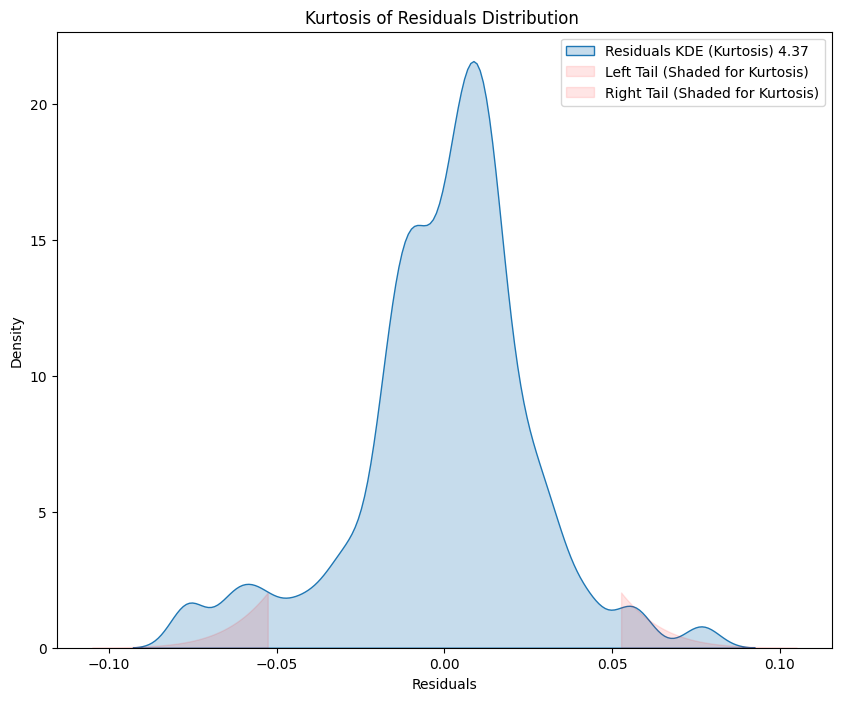

In [ ]:
#plot kurtosis of residuals distribution
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, kurtosis
mu = np.mean(fitted_model.resid)
sig = np.std(fitted_model.resid)
# Generating points for a normal distribution curve
x = np.linspace(mu - 4*sig, mu + 4*sig, 1000)
y = norm.pdf(x, mu, sig)

# Create the plot
plt.figure(figsize=(10, 8))
sns.kdeplot(fitted_model.resid, bw_adjust=0.5, fill=True, label='Residuals KDE (Kurtosis) 4.37')
normal_peak_y = norm.pdf(mu, mu, sig)
#plt.axhline(y=normal_peak_y, color='orange', linestyle='-', linewidth=2, label='Kurtosis: 3')

# Shade the tails to show the kurtosis visually
tail_shade = 0.1  # Adjust the transparency for tail shading
plt.fill_between(x, y, where=(x < mu - 2*sig), color='red', alpha=tail_shade, label='Left Tail (Shaded for Kurtosis)')
plt.fill_between(x, y, where=(x > mu + 2*sig), color='red', alpha=tail_shade, label='Right Tail (Shaded for Kurtosis)')

# Plot customization
plt.title('Kurtosis of Residuals Distribution ')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Because of curtosis in residuals,check kurtosis in growth rates
from scipy.stats import kurtosis
# Calculate kurtosis
log_gr_resid_kurt = kurtosis(quarter_gdp['log Growth Rate'], fisher=False)
print("Kurtosis:", log_gr_resid_kurt)

Kurtosis: 5.062198908065938


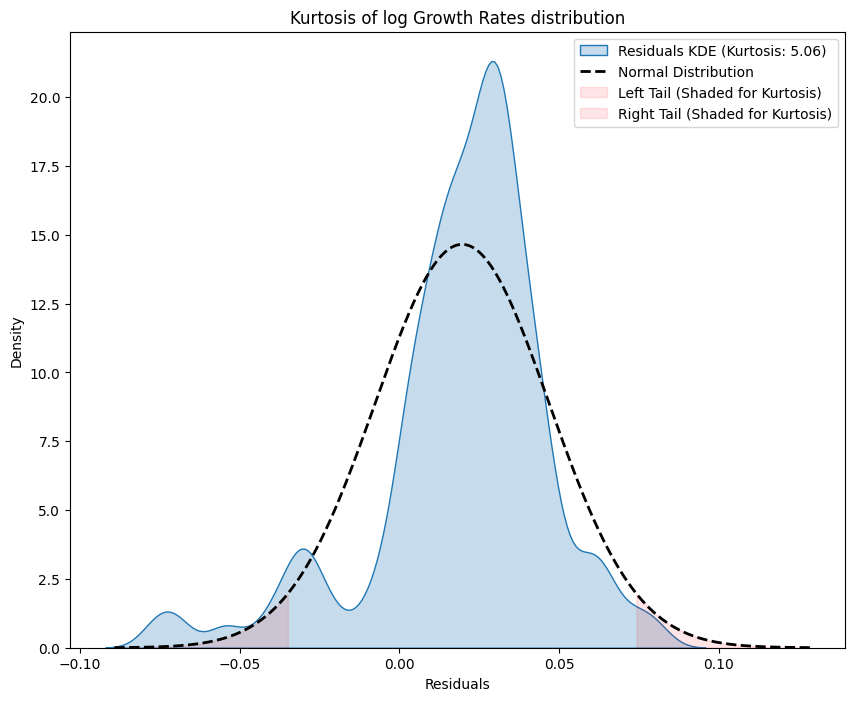

In [ ]:
#plot kurtosis of growth rates distribution
mu = np.mean(quarter_gdp['log Growth Rate'])
sig = np.std(quarter_gdp['log Growth Rate'])
# Generating points for a normal distribution curve
x = np.linspace(mu - 4*sig, mu + 4*sig, 1000)
y = norm.pdf(x, mu, sig)

# Create the plot
plt.figure(figsize=(10, 8))
sns.kdeplot(quarter_gdp['log Growth Rate'], bw_adjust=0.5, fill=True, label=f'Residuals KDE (Kurtosis: {log_gr_resid_kurt:.2f})')
plt.plot(x, y, 'k--', linewidth=2, label='Normal Distribution')

# Horizontal line for normal distribution peak (kurtosis = 3)
normal_peak_y = norm.pdf(mu, mu, sig)
#plt.axhline(y=normal_peak_y, color='orange', linestyle='-', linewidth=2, label='Kurtosis: 3')

# Shade the tails to show the kurtosis visually
tail_shade = 0.1  # Adjust the transparency for tail shading
plt.fill_between(x, y, where=(x < mu - 2*sig), color='red', alpha=tail_shade, label='Left Tail (Shaded for Kurtosis)')
plt.fill_between(x, y, where=(x > mu + 2*sig), color='red', alpha=tail_shade, label='Right Tail (Shaded for Kurtosis)')

# Plot customization
plt.title('Kurtosis of log Growth Rates distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend(loc='upper right')

plt.show()

In [ ]:
np.random.seed(24)  # Set a random seed for reproducibility

# Assuming fitted_model.resid, log_gr are previously defined
mu = np.mean(fitted_model.resid)
sig = np.std(fitted_model.resid)

# Initialize an array to store the generated residuals (for Monte Carlo simulation)
generated_residuals = np.zeros((len(log_gr), 1000))  # Using np.zeros for clarity and initialization to zero

# Generate 1000 sets of residuals (for Monte Carlo simulation)
for i in range(1000):
    # Generate new residuals (using normal distribution)
    resid_new = np.random.normal(loc=mu, scale=sig, size=len(log_gr))
    # Append the new residuals to the generated_residuals array
    generated_residuals[:, i] = resid_new

# Print the mean and standard deviation of the residuals
print("Mean of residuals:", mu)
print("Standard deviation of residuals:", sig)

# Display the generated residuals
residuals_df = pd.DataFrame(generated_residuals)
display(residuals_df)  # Ensure you're using this in an IPython environment, like Jupyter

Mean of residuals: -7.938739243559863e-06
Standard deviation of residuals: 0.02624602594821196


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.034879,0.026219,0.028608,-0.022131,-0.009627,0.045875,-0.001179,-0.038804,0.024772,0.057437,...,-0.006888,-0.012708,0.060408,0.023810,0.032516,-0.026684,-0.012531,-0.030418,-0.002756,-0.004197
1,-0.020218,0.022887,0.037452,-0.035823,-0.021533,-0.033228,0.002505,-0.021033,-0.018058,-0.021218,...,-0.019193,-0.030345,0.016663,-0.022916,0.033607,0.039970,-0.016505,-0.018095,0.013788,0.002905
2,-0.008309,-0.049035,0.018180,0.012601,0.041011,-0.012401,0.014015,0.033109,-0.039765,0.018440,...,-0.019192,-0.003515,-0.043798,0.018938,-0.022297,-0.013454,-0.003196,-0.039055,0.033420,0.011204
3,-0.026013,0.032294,0.004853,0.005193,-0.002692,0.003831,0.033890,-0.005825,-0.010335,0.052852,...,0.011320,-0.025187,0.008751,0.008508,0.007971,-0.019944,0.000828,0.009273,0.043913,0.023100
4,-0.028113,-0.003381,0.002812,0.003469,-0.012899,0.001292,-0.025304,0.029565,0.026187,-0.050662,...,-0.012887,0.015033,0.042613,0.026346,-0.014410,0.054883,0.016241,0.004585,0.035581,-0.020742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.022855,0.009223,-0.073656,-0.006909,0.012612,0.010519,-0.003751,-0.004650,-0.006910,0.006937,...,0.044250,0.056843,0.009605,-0.031284,-0.075025,-0.017315,-0.000502,-0.000455,0.023082,-0.034428
92,-0.025475,0.006960,-0.023879,0.004549,0.027088,0.023749,0.020343,-0.032856,0.025016,-0.025616,...,0.012134,-0.009743,-0.018442,0.016676,-0.035996,0.033841,-0.033605,-0.033166,0.004510,0.039101
93,0.011104,0.002767,0.058687,0.014731,0.007557,-0.029894,0.022519,0.034562,0.021717,0.019512,...,0.034844,0.027658,-0.031147,-0.017263,0.018489,0.009026,0.009641,-0.018280,0.030670,-0.015805
94,0.051808,-0.015170,-0.015143,0.026393,-0.011110,-0.059642,0.032219,-0.022884,-0.031328,-0.017467,...,0.038633,0.014491,0.007239,-0.024961,0.020552,-0.021034,0.022383,-0.020081,-0.015987,0.024644


In [ ]:
# Parameters from the fitted AR model
const = fitted_model.params['const']
AR = fitted_model.arparams[0]
print('Const:',const)
print('AR:',AR)

# Initialize arrays to store simulated GDP and log growth rates
sim_q_gdp = np.zeros([len(log_gr), 1000])
sim_log_gr = np.zeros([len(log_gr), 1000])

# Perform Monte Carlo simulation
for i in range(1000):
    for t in range(1, len(log_gr)):
        sim_log_gr[t, i] = const + AR * sim_log_gr[t-1, i] + generated_residuals[t, i]
        sim_q_gdp[:, i] = quarter_gdp['Quarter GDP'].iloc[0] * (np.exp(np.cumsum(sim_log_gr[:, i]))) #THIS LINE IS THE KEY
#Assign simulated data to a variable, so it can be reused
sim_q_gdp_df = pd.DataFrame(sim_q_gdp)
# Display the simulated GDP DataFrame
print('Simulated GDP DataFrame:')
display(sim_q_gdp_df)

# Display first value from original dataframe
print('First value from original dataframe:')
display(quarter_gdp['Quarter GDP'].iloc[0])

Const: 0.019621402364078014
AR: 0.262959379954952
Simulated GDP DataFrame:


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,...,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
1,1472.121096,1536.965406,1559.514893,1449.327692,1470.187168,1453.092505,1505.955780,1470.922669,1475.305213,1470.649714,...,1473.630716,1457.289209,1527.428710,1468.155392,1553.529825,1563.446066,1477.597611,1475.249599,1523.043958,1506.558190
2,1488.635153,1509.192069,1644.085530,1490.425472,1561.300608,1458.394701,1566.560964,1549.991102,1446.478728,1527.062064,...,1474.429693,1476.780557,1505.236626,1524.551051,1571.217015,1597.963122,1503.298909,1447.437845,1620.180133,1562.952800
3,1483.496416,1582.007899,1708.379597,1539.148300,1613.265654,1494.432072,1669.909672,1593.311050,1452.417299,1658.175045,...,1520.981182,1473.723561,1542.607247,1583.664783,1619.990506,1606.647654,1541.331174,1482.432955,1754.755928,1647.011143
4,1469.616138,1627.957363,1764.850182,1588.481502,1638.191438,1535.841018,1688.577053,1685.814870,1522.136239,1642.694660,...,1543.826310,1524.858576,1652.281027,1674.831179,1641.598973,1733.390741,1608.140631,1528.325581,1893.664780,1667.986678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,20309.617887,19472.772441,10955.332924,9899.128988,10569.287610,24682.792287,19043.769881,19465.718137,14844.419360,34935.815186,...,10791.511099,22782.635341,15061.869482,35600.366644,21345.809021,16829.410109,33957.190608,17430.948547,14533.734275,38619.785837
92,20431.084197,20091.337109,10802.419777,10219.798984,11170.902534,25963.684982,19973.616330,19286.851490,15597.896052,35111.126313,...,11347.876081,23571.815345,15222.785381,36890.794474,20700.122212,17774.252101,33737.699205,17375.203039,15094.317780,40918.053759
93,21101.633345,20715.865650,11639.247636,10666.013774,11646.995153,26042.513288,21096.108138,20311.339938,16469.239674,36560.460763,...,12142.547310,24935.323607,15090.456278,37325.737250,21331.244984,18555.423670,34680.332201,17383.880780,16031.599268,41703.656985
94,22857.327011,20976.453112,11923.143220,11294.485837,11876.172046,25040.815110,22540.331070,20522.585256,16511.913885,37031.121762,...,13102.041424,26184.962059,15465.743298,37241.573062,22381.709659,18739.984194,36431.117970,17378.178701,16346.894351,43809.676603


First value from original dataframe:


1473

In [ ]:
# Create a DatetimeIndex for the DataFrame
index = pd.date_range(start='2000-01-01', periods=len(log_gr), freq='Q')
# Add index
sim_q_gdp_df.index = index
# Display quarterly simulated gdp values
display(sim_q_gdp_df)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2000-03-31,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,...,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
2000-06-30,1472.121096,1536.965406,1559.514893,1449.327692,1470.187168,1453.092505,1505.955780,1470.922669,1475.305213,1470.649714,...,1473.630716,1457.289209,1527.428710,1468.155392,1553.529825,1563.446066,1477.597611,1475.249599,1523.043958,1506.558190
2000-09-30,1488.635153,1509.192069,1644.085530,1490.425472,1561.300608,1458.394701,1566.560964,1549.991102,1446.478728,1527.062064,...,1474.429693,1476.780557,1505.236626,1524.551051,1571.217015,1597.963122,1503.298909,1447.437845,1620.180133,1562.952800
2000-12-31,1483.496416,1582.007899,1708.379597,1539.148300,1613.265654,1494.432072,1669.909672,1593.311050,1452.417299,1658.175045,...,1520.981182,1473.723561,1542.607247,1583.664783,1619.990506,1606.647654,1541.331174,1482.432955,1754.755928,1647.011143
2001-03-31,1469.616138,1627.957363,1764.850182,1588.481502,1638.191438,1535.841018,1688.577053,1685.814870,1522.136239,1642.694660,...,1543.826310,1524.858576,1652.281027,1674.831179,1641.598973,1733.390741,1608.140631,1528.325581,1893.664780,1667.986678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,20309.617887,19472.772441,10955.332924,9899.128988,10569.287610,24682.792287,19043.769881,19465.718137,14844.419360,34935.815186,...,10791.511099,22782.635341,15061.869482,35600.366644,21345.809021,16829.410109,33957.190608,17430.948547,14533.734275,38619.785837
2023-03-31,20431.084197,20091.337109,10802.419777,10219.798984,11170.902534,25963.684982,19973.616330,19286.851490,15597.896052,35111.126313,...,11347.876081,23571.815345,15222.785381,36890.794474,20700.122212,17774.252101,33737.699205,17375.203039,15094.317780,40918.053759
2023-06-30,21101.633345,20715.865650,11639.247636,10666.013774,11646.995153,26042.513288,21096.108138,20311.339938,16469.239674,36560.460763,...,12142.547310,24935.323607,15090.456278,37325.737250,21331.244984,18555.423670,34680.332201,17383.880780,16031.599268,41703.656985
2023-09-30,22857.327011,20976.453112,11923.143220,11294.485837,11876.172046,25040.815110,22540.331070,20522.585256,16511.913885,37031.121762,...,13102.041424,26184.962059,15465.743298,37241.573062,22381.709659,18739.984194,36431.117970,17378.178701,16346.894351,43809.676603


In [ ]:
#Load original annual GDP from Eurostat
def load_and_check(annual_gdp):
    if annual_gdp.shape[0] != 24: # number of rows(indexed as [0]) in the created pandas dataframe should match the amount of rows in .csv file
        print('Please check if data was loaded properly, different shape was expected.')
    else:
        print('Data loaded properly.')
    return annual_gdp
url = "https://drive.google.com/uc?id=1CFulC9DNeJ1O44xW-cKUeYDwlfn6aIPG&export=download"
annual_gdp = pd.read_csv(url)
display(load_and_check(annual_gdp))

Data loaded properly.


,Year,Annual GDP
0,2000,6172
1,2001,6987
2,2002,7823
3,2003,8744
4,2004,9778
5,2005,11343
6,2006,13569
7,2007,16401
8,2008,16618
9,2009,14132


In [ ]:
# Ensure the index for annual_gdp is set to the Year column and is of datetime type
annual_gdp.set_index(pd.to_datetime(annual_gdp['Year'], format='%Y'), inplace=True)

# Prepare an empty DataFrame with the correct shape: 96 quarters x 1000 simulations
normalized_sim_q_gdp_df = pd.DataFrame(index=sim_q_gdp_df.index, columns=range(sim_q_gdp_df.shape[1]))

# Normalize Quarterly Simulated Values
for i in range(normalized_sim_q_gdp_df.shape[1]):  # iterating over each simulation
    sim_data = sim_q_gdp_df.iloc[:, i]  # get the simulation column
    sim_data_yearly = sim_data.resample('A-DEC').sum()  # sum quarterly data to annual

    for year in sim_data_yearly.index.year:
        if year in annual_gdp.index.year:
            yearly_total = sim_data_yearly[sim_data_yearly.index.year == year].iloc[0]
            annual_gdp_value = annual_gdp.loc[pd.Timestamp(year=year, month=1, day=1)]['Annual GDP']

            # Normalize quarterly values
            quarter_mask = (sim_data.index.year == year)
            normalized_quarters = (sim_data[quarter_mask] / yearly_total) * annual_gdp_value

            # Assign normalized values to the corresponding year and simulation column
            normalized_sim_q_gdp_df.loc[normalized_quarters.index, i] = normalized_quarters.values

# Convert all columns to float
normalized_sim_q_gdp_df = normalized_sim_q_gdp_df.astype(float)

# Ensure the index is sorted and set as a datetime index
normalized_sim_q_gdp_df.sort_index(inplace=True)

# Verification by Resampling Annually and Comparing with Actual Annual GDP
resampled_annual_values = normalized_sim_q_gdp_df.resample('A-DEC').sum()

# Create the comparison DataFrame if resampling produced a non-empty DataFrame
if not resampled_annual_values.empty:
    common_years = set(resampled_annual_values.index.year).intersection(set(annual_gdp.index.year))
    resampled_annual_values = resampled_annual_values[resampled_annual_values.index.year.isin(common_years)]
    annual_gdp_filtered = annual_gdp[annual_gdp.index.year.isin(common_years)]

    # Convert common_years set to a sorted list for DataFrame index
    common_years_list = sorted(list(common_years))

    comparison_df = pd.DataFrame({
        'Simulated Normalised Annual GDP': resampled_annual_values.iloc[:, 0].values,
        'Actual Annual GDP': annual_gdp_filtered['Annual GDP'].values
    }, index=common_years_list)

    print(comparison_df)
else:
    print("resampled_annual_values is empty after resampling. Check resample method.")


      Simulated Normalised Annual GDP  Actual Annual GDP
2000                           6172.0               6172
2001                           6987.0               6987
2002                           7823.0               7823
2003                           8744.0               8744
2004                           9778.0               9778
2005                          11343.0              11343
2006                          13569.0              13569
2007                          16401.0              16401
2008                          16618.0              16618
2009                          14132.0              14132
2010                          14741.0              14741
2011                          16677.0              16677
2012                          17917.0              17917
2013                          18911.0              18911
2014                          20048.0              20048
2015                          20631.0              20631
2016                          2

In [ ]:
display(normalized_sim_q_gdp_df)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2000-03-31,1536.415042,1490.101553,1423.866006,1527.470852,1486.061199,1546.433208,1462.708331,1493.514083,1554.821807,1483.361704,...,1530.005447,1545.940402,1503.132651,1502.859663,1462.164690,1456.701362,1516.432146,1546.643380,1426.994901,1468.830033
2000-06-30,1535.498299,1554.809599,1507.495073,1502.923153,1483.223426,1525.533269,1495.433853,1491.407822,1557.255070,1480.994885,...,1530.660572,1529.451640,1558.674790,1497.916848,1542.102142,1546.146649,1521.165320,1549.005449,1475.475873,1502.293222
2000-09-30,1552.723314,1526.713813,1589.244737,1545.540710,1575.144776,1531.099793,1555.615596,1571.577421,1526.827339,1537.804063,...,1531.490469,1549.908166,1536.028730,1555.455722,1559.659226,1580.281776,1547.624434,1519.803232,1569.578268,1558.528183
2000-12-31,1547.363345,1600.375036,1651.394184,1596.065285,1627.570599,1568.933730,1658.242220,1615.500674,1533.095784,1669.839348,...,1579.843512,1546.699793,1574.163829,1615.767768,1608.073942,1588.870214,1586.778100,1556.547940,1699.950958,1642.348562
2001-03-31,1732.733475,1609.991932,1709.333161,1608.286917,1640.713812,1638.959273,1741.406745,1619.387276,1702.079356,1721.700886,...,1688.141908,1685.142668,1711.330607,1582.831142,1715.403855,1620.576916,1664.690002,1657.479832,1680.645741,1681.992796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,9395.747179,9051.601932,9102.923612,9518.770209,9195.597550,9202.763550,9517.560224,9163.207829,9307.260364,9653.053779,...,9611.550928,10037.309133,9490.623159,9158.294260,8672.435709,9129.232420,9445.778923,9694.220907,9596.290694,9271.860790
2023-03-31,8710.338032,9119.392256,8678.158239,8830.905425,8918.645270,9541.749305,8714.095288,9031.449101,8915.465207,9100.975385,...,8386.805961,8633.557117,9215.236384,9390.102745,8859.916746,8984.445033,8908.791552,9327.458539,8867.700787,8961.381934
2023-06-30,8996.211738,9402.863720,9350.426557,9216.478626,9298.748952,9570.718996,9203.816349,9511.186049,9413.508900,9476.649951,...,8974.118807,9132.963984,9135.129890,9500.812135,9130.045355,9379.307949,9157.703631,9332.116975,9418.340565,9133.435341
2023-09-30,9744.712658,9521.143517,9578.494976,9759.539929,9481.719612,9202.591248,9833.902361,9610.105841,9437.900679,9598.647580,...,9683.246304,9590.664199,9362.312926,9479.389165,9579.657656,9472.598731,9620.016884,9329.055951,9603.572021,9594.670527


In [ ]:
#Load original annual consumption aggregates from Eurostat
def load_and_check(annual_cons):
    if annual_cons.shape[0] != 24: # number of rows(indexed as [0]) in the created pandas dataframe should match the amount of rows in .csv file
        print('Please check if data was loaded properly, different shape was expected.')
    else:
        print('Data loaded properly.')
    return annual_cons
url = "https://drive.google.com/uc?id=1NY4nmAB4zZ3WTAdXTrDSLCyAu0vTJWIA&export=download"
annual_cons = pd.read_csv(url)
display(load_and_check(annual_cons))

Data loaded properly.


,Year,Annual cons agg
0,2000,3636
1,2001,4113
2,2002,4588
3,2003,5043
4,2004,5709
5,2005,6486
6,2006,7591
7,2007,8742
8,2008,8997
9,2009,7753


In [ ]:
# Convert the first column to datetime and set as the index
annual_cons.index = pd.to_datetime(annual_cons.iloc[:, 0], format='%Y')
annual_cons.drop(annual_cons.columns[0], axis=1, inplace=True)  # Drop the redundant column if needed
display(annual_cons)

,Annual cons agg
Year,
2000-01-01,3636
2001-01-01,4113
2002-01-01,4588
2003-01-01,5043
2004-01-01,5709
2005-01-01,6486
2006-01-01,7591
2007-01-01,8742
2008-01-01,8997


,Year,Interpolated Value
0,2000-03-31,3746.898086
1,2000-06-30,3864.506746
2,2000-09-30,3987.142281
3,2000-12-31,4111.643459
4,2001-03-31,4233.421908
...,...,...
91,2022-12-31,19558.302595
92,2023-03-31,19286.588257
93,2023-06-30,18661.907878
94,2023-09-30,17622.606471


        Year  Interpolated Value
0 2000-03-31         3746.898086
1 2000-06-30         3864.506746
2 2000-09-30         3987.142281
3 2000-12-31         4111.643459
4 2001-03-31         4233.421908


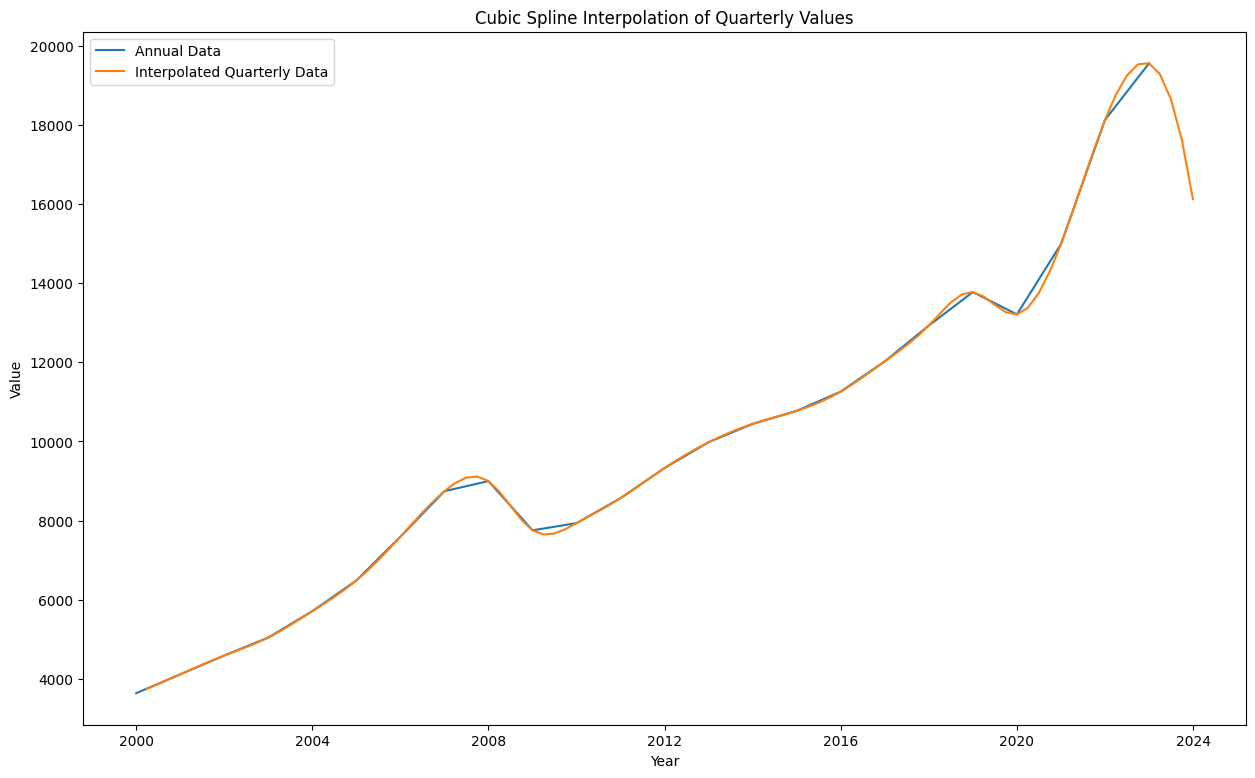

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline

# Example annual data
years = annual_cons.index.to_numpy()
values = annual_cons['Annual cons agg'].to_numpy()

# Create cubic spline interpolation
cs = CubicSpline(years, values)

# Define quarterly points
quarterly_points = normalized_sim_q_gdp_df.index.to_numpy()

# Interpolate values
quarterly_values = cs(quarterly_points)

# Create a DataFrame to see the results
quarterly_data = pd.DataFrame({
    'Year': quarterly_points,
    'Interpolated Value': quarterly_values
})
display(quarterly_data)
print(quarterly_data.head())
plt.figure(figsize=(15, 9))
plt.plot(years, values, label='Annual Data')
plt.plot(quarterly_points, quarterly_values, label='Interpolated Quarterly Data')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Cubic Spline Interpolation of Quarterly Values')
plt.show()